In [2]:
from Crypto.Util.number import sieve_base

**Thanks ciphr from the CryptoHack community for helping me with the code and resources**

# Prerequisites

- RSA
- Coppersmith attacks
- Pohlig-hellman discrete algorithm
- Group theory

We'll change the format to (theory, code) pairs instead of the classic theory then code

# Theory (ROCA = Return of Coppersmith's attack)

*Idea*: The random primes generated for the RSA weren't that random and had an inderesting distribution (non-uniform) of public keys $N$ modulo small primes (11, 13, 17, 19)

## Setup

- $N$ is public number modulus $N = p\cdot q$
- $p_\text{ideal} = \text{random prime}$. This can't happen that easily in practice (Ex: mobile phones might not have an option to generate random numbers). Therefore we need a faster way to generate a prime
- $p_\text{infineon} = k \cdot M + 65537^a \bmod  M $ with $ a,k \in \mathbb{Z}$ and unknown
- $M = P_n\# = \Pi_{i=1}^n P_i = 2 \cdot 3 \cdot ... \cdot P_n $ where $P_i$ = the $i$'th prime. $M$ = product of the first $n$ primes and it's called a **Primorial**
    - [Primorial](https://en.wikipedia.org/wiki/Primorial)
    - $n$ is a constant that depends only on the desired key size
    - Ex: for key sizes between 512 and 960 $n = 39$

In [3]:
def primorial(n: int):
    """Generate the primorial from the first n primes

    Parameters
    ----------
    n : int
        The number of primes

    Returns
    -------
    int
        desired Primorial
    """
    M = 1
    for p in sieve_base[:n]: # the first n primes
        M*=p
    return int(M)

n = 39
M = primorial(n)

In [4]:
#The number of known bits
print(log(M, 2).n())

219.192783193251


**Observations**:
- Security is dependant only on the secret constants $k$ and $a$
- The size of $M$ is big (comparable to the size of $p$) => The sizes of $k$ and $a$ are small.
- therefore the resulting primes will suffer  from a significant loss in entropy (M is the same for multiple primes)

**Task**:
- Find prime divisor $p$ of the given form

In [5]:
# https://bitsdeep.com/posts/analysis-of-the-roca-vulnerability/
def get_parameter_sizes(key_size: int):
    if 512 <= key_size <= 960:
        n = 39
    elif 992 <= key_size <= 1952:
        n = 71
    elif 1984 <= key_size <= 3936:
        n = 126
    elif 3968 <= key_size <= 4096:
        n = 225
    else:
        print("Invalid key size.")
        return None
    M = primorial(n)
    k_size = key_size//2 - round(log(M, 2))
    a_size = ceil(log(Zmod(M)(65537).multiplicative_order(), 2))
    return M, k_size, a_size

In [7]:
M, k_size, a_size = get_parameter_sizes(512)

In [8]:
#lets look at the key sizes
print(log(M, 2).n(), k_size, a_size)
print("Secure bit size: ",k_size + a_size )

219.192783193251 37 62
Secure bit size:  99


In [11]:
def gen_weak_prime(M: int, k_size: int, a_size: int):
    from Crypto.Util.number import getRandomNBitInteger

    p = 0
    while not is_prime(p):
        k = getRandomNBitInteger(k_size)
        a = getRandomNBitInteger(a_size)
        p = k * M + pow(int(65537), a, M)
    return p


def gen_weak_key(size: int):
    params = get_parameter_sizes(size)
    if params is not None:
        M, k_size, a_size = params
        n = int(0)
        # Can happen sometimes
        while n.bit_length() != size:
            p1 = gen_weak_prime(M, k_size, a_size)
            p2 = gen_weak_prime(M, k_size, a_size)
            n = p1 * p2
        return n


In [12]:
N = gen_weak_key(512)
print(N)

9444136344499128327346292040711447020538099775980505213280214181506960316870916075806763328777811096218868170925181745411655441470171526866430532608258639


## Fingerprinting

[Wikipedia entry](https://en.wikipedia.org/wiki/Fingerprint_(computing))

**Fingerprinting - Definition**  
    In computer science, a fingerprinting algorithm is a procedure that maps an arbitrarily large data item (such as a computer file) to a much shorter bit string, its fingerprint, that **uniquely** identifies the original data for all practical purposes

For our case:  
$$N = \underbrace{(k \cdot M + 65537^a \bmod  M)}_p \cdot \underbrace{(l \cdot M + 65537^b \bmod M)}_q \text{ for } a, b, k, l \in \mathbb{Z}$$
Therefore:  
$$ N\equiv 65537^{a+b} \equiv 65537^c \bmod  M \text{ for some } c \in \mathbb{Z} => N \text{ has the same form as } p,q $$
So the public modulus $N$ is generated by $65537$ in the multiplicative group $\mathbb{Z}^*_M$ => We use the discrete logarithm to fingerprint => $c$ is our fingerprint
- Pohlig-Hellman (works for groups $G$ whose size $|G|$ is a smooth number) 
    - $G$ is a subgroup of $\mathbb{Z}^*_M$ which is generated by $65537$
    - The size $|\mathbb{Z}^*_M| = \varphi(M)$ where $M$ is smooth (Primorial)
    - Therefore $|G|$ divides $|\mathbb{Z}^*_M| = \varphi(M) => $ Ex: for 512 bit key $|G| = 2^4∗3^4∗5^2∗7∗11∗13∗17∗23∗29∗37∗41∗53∗83$ regardless of key size => Smaller search space

In [13]:
g = 65537
order_M = Zmod(M)(g).multiplicative_order()
print(order_M)
print(factor(order_M))

2454106387091158800
2^4 * 3^4 * 5^2 * 7 * 11 * 13 * 17 * 23 * 29 * 37 * 41 * 53 * 83


## Factorization

*Idea*: 
- We want to find $p$ or $q$
- If we find $k$ and $a$ we found $p$
- We want to "guess" (smartly iterate through values) the $a$ then use Coppersmith to find $k$ => we will find $p$ if we correctly guessed $a$. The search space is bounded by the order of $a$ (denoted as $\text{ord}_M(65537)$)

### Optimization (the code might take a while)

- Optimize $M$
    - The bitsize of $M$ is analogous with the number of known bits for $p$ in Coppersmith's algo (M has an even bigger size than required $\log_2(M) > \log_2(N)/4$)
    - $a$ is bounded by the order of $g = 65537$ in $\mathbb{Z}^*_M$
    - The idea is to find a smaller $M'$ that divides $M$ s.t primes and $N$ keep their form. We want $M'$ to be big enough (for Coppersmith bitsize) but the order of $g$ in $\mathbb{Z}^*_M$ to be small enough to be feasible to search for an $a^\prime$ 
    - We can search through the divisors $\text{ord}_{M'}(65537)$ of $\text{ord}_{M}(65537)$ iteratively then compute $M'$ and check if it's optimal enough
- Optimize the search space for $a$:
    - Naive idea: brute force: guess $a'$ from $x = 0, 1, ...$ to find $p = 65537^{a'}  \ mod \ M'$ => we are looking for $x \equiv a' \bmod \text{ord}_{M'}(65537)$
    - We can search for either $p$ or $q$ since they are of the same form => We can halve the interval to some subset 
    - we can search for between $\Big [\frac {c'} 2, \frac {c'+\text{ord}_{M'}(65537)} 2 \Big ]$

*Order of a generator in* $\mathbb{Z}^*_{M'}$
- $\text{ord}_{M'}(65537) = \text{lcm}(ord_{P_1}, ...) \text{ for } P_i | M'$

In [20]:
def maximal_divisor_M(M: int, order_M_prime: int, g: int):
    M_prime = M
    for P, e in factor(M): #each prime in the first n primes
        order_P = Zmod(P)(g).multiplicative_order()
        if order_M_prime % order_P != 0: #if the order of M_prime is divisible by the order of M then we don't care about that prime
            M_prime /= P
    return int(M_prime)


def optimal_M_prime(M: int, g: int, N: int):
    #Get the bit threshold for log_2(N) / 4
    bit_threshold = log(N, 2) / 4
    
    #get order of M
    order_M = Zmod(M)(g).multiplicative_order()
    print('search space: ', len(divisors(order_M)))
    
    #Get all M_primes
    M_prime_list = []
    for order_M_divisor in reversed(divisors(order_M)):
        M_prime = maximal_divisor_M(M, order_M_divisor, g)
        if log(M_prime, 2) >= bit_threshold:
            M_prime_list.append((M_prime, Zmod(M_prime)(g).multiplicative_order()))
            if len(M_prime_list) % 1000 == 0:
                print(len(M_prime_list))
            
    #sort the list
    #M_prime_list.sort()
    
    return M_prime_list


In [21]:
len(divisors(order_M))

76800

In [22]:
#M = primorial(39)
M = primorial(40)

In [23]:
# This line takes a while
M_primes = optimal_M_prime(M, g, N)

search space:  153600
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


In [24]:
# Sort by order
sorted_M_primes_ord = sorted(M_primes.copy(), key = lambda x: x[1])
# Sort by value
sorted_M_primes_M = sorted(M_primes.copy(), key = lambda x: x[0])

In [25]:
sorted_M_primes_ord[0][0].bit_length(), int(log(N, 2) / 4)

(128, 127)

In [29]:
len(sorted_M_primes_ord)

29464

## Optimization 2

We took some values from this paper:  https://comserv.cs.ut.ee/home/files/produit_cybersecurity_2019.pdf?study=ATILoputoo&reference=2ABC6CF8AB89C13221B4FAD657192FF787E425C1

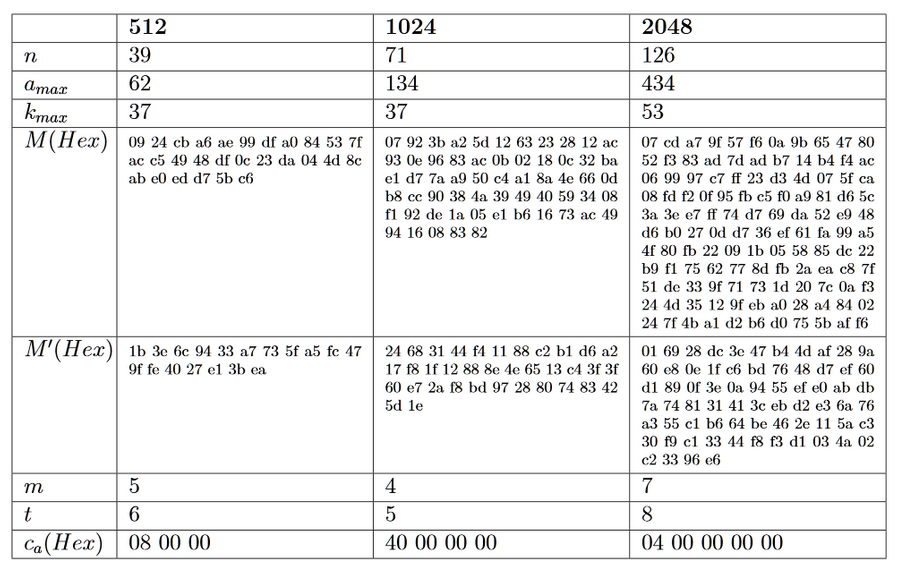

In [30]:
M_prime = 0x1b3e6c9433a7735fa5fc479ffe4027e13bea
print(M_prime)

2373273553037774377596381010280540868262890


In [46]:
test_m = (M_prime, Zmod(M_prime)(g).multiplicative_order())
print(test_m)

(2373273553037774377596381010280540868262890, 1201200)


In [47]:
test_m in M_primes

True

In [48]:
sorted_M_primes_M.index(test_m), sorted_M_primes_ord.index(test_m), 

(11175, 8)

### Coppersmith

- Since $p = k'\cdot M\ + (65537^{a'} \ mod \ M') \overset{x=k'}{=>} f(x) = x\cdot M' + (65537^{a'} \ mod \ M') \ mod \ N \overset{\text{make monic}}{\iff} f(x) = x + (65537^{a'} \ mod \ M') \cdot (M^{-1}\ mod \ N) \ mod N$
- Since the bitsize of $p$ is half the bitsize of $N$ => $\beta = 0.5$.
- X is the upper bound of our root => $X = 2\cdot N^{0.5} / M'$
- for 512bits  $m = 5$

In [65]:
## Coppersmith-howgrave
def coppersmith_howgrave(f, N, beta, m, t, R):
    #Check if parameters are within bounds
    assert 0 < beta <= 1, 'beta not in (0, 1]'
    assert f.is_monic(), 'f is not monic'
    
    #get delta and the matrix dimension
    delta = f.degree()
    n = delta * m + t
    
    #Building the polynomials
    fZ = f.change_ring(ZZ) #change the ring from Zmod(N) to ZZ
    x = fZ.parent().gen()  #make x a variable in ZZ
    f_list = [] 
    for ii in range(m):
        for j in range(delta):
            #We want them ordered that's we have N^(m-ii1) and fZ^ii
            f_list.append(((x*R)^j) * N^(m-ii) * fZ(x*R)^(ii)) #the g_{i,j}
    for ii in range(t):
        f_list.append((x*R)^ii * fZ(x*R)^m) #the h_i
        
    #Build the lattice
    B = matrix(ZZ, n) # n = delta * m + t
    for ii in range(n):
        for j in range(ii+1):
            B[ii, j] = f_list[ii][j]
            
    #LLL it
    B_lll = B.LLL(early_red = True, use_siegel = True)

    #take the shortest vector to construct our new poly g
    g = 0
    for ii in range(n):
        g += x^ii * B_lll[0, ii] / R^ii
    
    g = g.change_ring(ZZ)
    #factor the polynomial
    potential_roots = g.roots()
    #print('potential roots:', potential_roots)
    
    #we don't need to do this Since our we test in our roca function
    #     #test roots
    #     roots = []
    #     for r in potential_roots:
    #         if r[0].is_integer():
    #             res = fZ(ZZ(r[0]))
    #             if gcd(N, res) >= N^beta:
    #                 roots.append(ZZ(r[0]))
    #print('roots:', roots)
    return potential_roots
    #return roots

### Algorithm

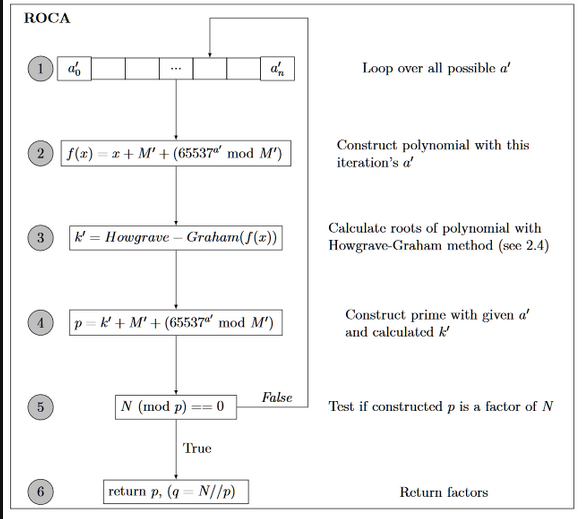
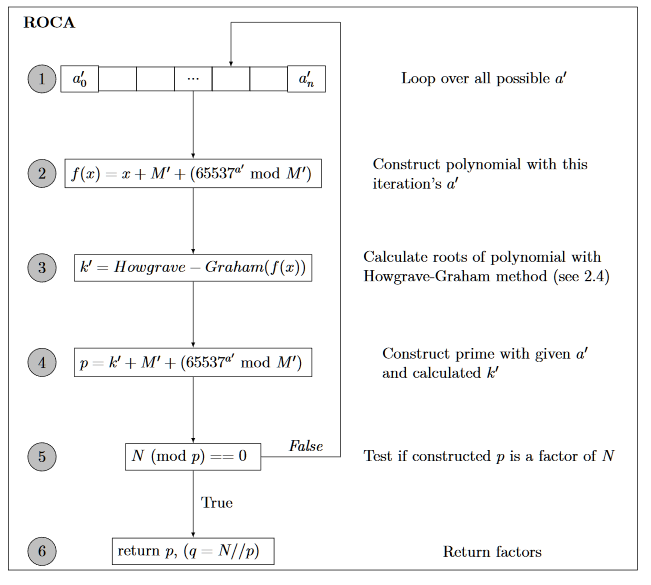

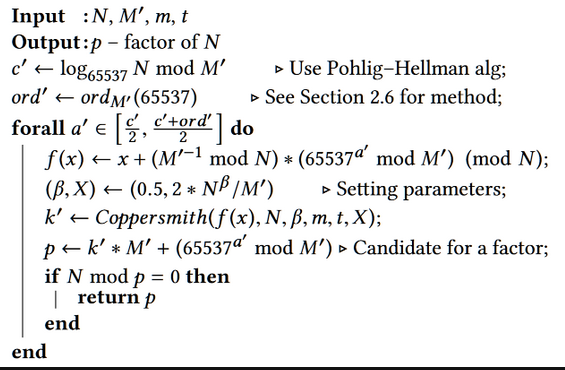
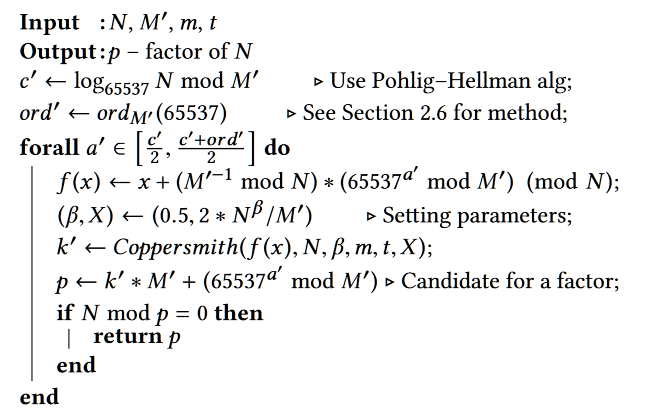

In [36]:
#Experimentally determined from the paper
def get_m_t_values(key_size):
    if 512 <= key_size < 1024:
        m = 5
    elif 1024 <= key_size < 2048:
        m = 4
    elif 2048 <= key_size < 3072:
        m = 6
    elif 3072 <= key_size < 4096:
        m = 25
    else:
        m = 7
    return m, m+1

In [66]:
def roca(N, M_prime, g, m, t, beta, iter_to_print: int = 1000):
    g = int(g)
    c_prime = discrete_log(Zmod(M_prime)(N), Zmod(M_prime)(g))
    ord_M_prime = Zmod(M_prime)(g).multiplicative_order()
    
    #search boundaries
    bottom = c_prime // 2 
    top =(c_prime + ord_M_prime) // 2 
    print('numbers to check',   top - bottom, ' between ', (bottom, top))
    #cheat (remove this for full time)
    bottom = 129328
    
    #constants for coppersmith
    P.<x> = PolynomialRing(Zmod(N))
    epsilon = beta / 7
    X = floor(2 * N^beta / M_prime)
    
    #the search
    for i, a in enumerate(range(bottom, top)):
        if i % iter_to_print == 0: #count iterations
            print(i)
            
        #construct polynomial
        f = x + int((inverse_mod(M_prime, N)) * int(pow(g, a, M_prime)))

        #roots = f.small_roots(X, beta, epsilon) #coppersmith
        roots = coppersmith_howgrave(f, N, beta, m, t, X)
        #check solutions
        
        for k_prime, _ in roots:
            p = int(k_prime * M_prime) + int(pow(g, a, M_prime))
            if N % p == 0:
                return p, N//p
    return None, None
        

In [38]:
M, k_size, a_size = get_parameter_sizes(512)
p = gen_weak_prime(M, k_size, a_size)
q = gen_weak_prime(M, k_size, a_size)
N = p*q
print(k_size, a_size)
print(N)

37 62
10862317534684543051598770798473034002220244129741316337225493176222119449118328645175011172767475208767681414570564139076273064681535282623560122556734797


In [40]:
m, t = get_m_t_values(512)

In [45]:
N, M_primes[-1], g, m, t

(10862317534684543051598770798473034002220244129741316337225493176222119449118328645175011172767475208767681414570564139076273064681535282623560122556734797,
 (328782546775534004435549943458065873590, 327600),
 65537,
 5,
 6)

In [ ]:
#this might take very long
#p_found, q_found = roca(N, M_primes[-1][0], g, m, t, .5) 

In [68]:
#custom N for finding fast
N=4013610727845242593703438523892210066915884608065890652809524328518978287424865087812690502446831525755541263621651398962044653615723751218715649008058509 
e=65537
int(N).bit_length()

511

In [69]:
m = 5
t = 6
M = primorial(40)
# we use the optimized M_prime
p, q = roca(N, M_prime, e, m, t, .5) #remove the cheat for full time ( it might take minutes / hours)

numbers to check 600600  between  (119319, 719919)
0


In [70]:
p * q == N

True

# The code can be parallelized

# Resources

- https://en.wikipedia.org/wiki/ROCA_vulnerability
- ROCA paper: https://acmccs.github.io/papers/p1631-nemecA.pdf
- ROCA talk https://www.youtube.com/watch?v=lg7FAO730Q8&t
- https://shainer.github.io/crypto/math/2017/12/03/the-return-of-coppersmith.html
- https://bitsdeep.com/posts/analysis-of-the-roca-vulnerability/
- Presentation and optimization https://comserv.cs.ut.ee/home/files/produit_cybersecurity_2019.pdf?study=ATILoputoo&reference=2ABC6CF8AB89C13221B4FAD657192FF787E425C1 